### CART原理
k-近邻算法可以实现分类的功能 但它无法给出数据的内在含义 决策树的优势在于数据形式比较容易理解

决策树优点：计算复杂度不高，输出结果易于理解，对中间值的缺失不敏感，可以处理不相关特征数据。
缺点：可能会有过度匹配问题。

生成决策树可以通过二分法划分数据，但一般采用[ID3算法](https://en.wikipedia.org/wiki/ID3_algorithm)、[C4.5算法](https://en.wikipedia.org/wiki/C4.5_algorithm)或者CART

决策树的目标是对数据进行划分 而数据划分的大原则是:**将无序的数据变得有序**。这存在多种方法，但是每种方法都存在各自的优缺点。组织杂乱无章的数据的一种比较好的方法就是使用**信息论**度量信息。

香农熵:$$Entropy(S)=-\sum_{i=1}^np(x_i)log_2p(x_i)$$

香农熵越高表示混合的数据越多

信息增益:$$Gain(S,A)=Entropy(S)-\sum_{v\in Values(A)}\frac{|S_v|}{|S|}Entropy(S_v)$$

在划分数据集前后信息发生的变化。

$Entropy(S)$可以用于表示集合的混乱程度 S为整个集合 A为一个特征 v为特征的一个值 如flippers为一个特征 1和0为其值。$S_v$表示特征A为v的子集 而$Entropy(S_v)$就是这个子集$S_v$的混乱程度。我们希望$S_v$越不混乱越好，即通过v这个特征的值可以对目标进行区分 此时得到的信息增益值也是最大的

In [11]:
#香农熵的计算
from math import log

#根据两个labels特征判断是否为鱼
#生成数据集
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    return dataSet, labels

def calcShannonEnt(dataSet):
    numEntries = len(dataSet)#获取数据集长度 即条数
    labelCounts = {} #用于统计各个结果的个数 如yes：2 no：3
    for featVec in dataSet: 
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries #选择该分类的概率 如yes就为2/5
        shannonEnt -= prob * log(prob,2) #香农熵
    return shannonEnt
myDat,labels=createDataSet()
print(myDat)
print(calcShannonEnt(myDat))

#为输入数据集增加数据分类 观察香农熵的变化

myDat[0][-1]='maybe'
print(myDat)
print(calcShannonEnt(myDat))
#最终输出结果为对应数据集合的香浓熵

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
0.9709505944546686
[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
1.3709505944546687


**通过上述代码我们可以计算得到数据集的香农熵 用于度量数据集的无序情况**

**为了有效划分数据 我们需要对每个特征划分数据集的结果计算信息熵 然后得出最好的划分办法**

In [19]:
def splitDataSet(dataSet, axis, value):#对dataSet数据集的axis列关于value值进行划分
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]    
            reducedFeatVec.extend(featVec[axis+1:])#关于extend方法见下面演示
            retDataSet.append(reducedFeatVec)
    return retDataSet
print(myDat)
print(splitDataSet(myDat,0,1))
print(splitDataSet(myDat,0,0))

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
[[1, 'maybe'], [1, 'yes'], [0, 'no']]
[[1, 'no'], [1, 'no']]


In [13]:
#append与extend的区别 一个是直接增加元素，另一个是拆分list中元素
a=[1,2,3]
b=[1,2,3]
a.append(b)
a.extend(b)
print(a)

[1, 2, 3, [1, 2, 3]]
[1, 2, 3, [1, 2, 3], 1, 2, 3]


In [28]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        #计算每种划分对应的香农熵 并获取最大信息对应的序列号i
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)     
        infoGain = baseEntropy - newEntropy  
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain   
            bestFeature = i
    return bestFeature 
chooseBestFeatureToSplit(myDat)

0

**从上述的结果我们可以发现第0序列的元素所产生的的信息增益最大 即通过该特征进行划分可以得到较好的结果**

In [66]:
import operator
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]#返回出现次数最多的分类名称

def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList): 
        return classList[0]#停止划分直至所有类比都相同
    if len(dataSet[0]) == 1: 
        return majorityCnt(classList)#遍历完所有特征值后返回次数最多的
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])#del用于删除变量
    featValues = [example[bestFeat] for example in dataSet]#获取列表包含的所有特征的值
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]      
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree
myDat,labels=createDataSet()
myTree=createTree(myDat,labels)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

**通过上述算法 我们成功构建了决策树 为了能更好的展现结果 我们可以对其进行作图 主要借助matplotlib.pyplot**

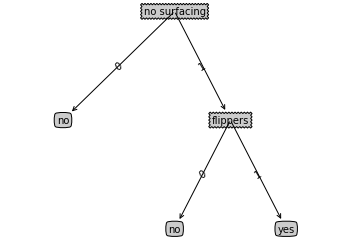

In [59]:
import matplotlib.pyplot as plt

#定义箭头与文本框的格式
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

#创建树 这里存储了两个树 通过键入值返回对应的树
def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

#获取节点数目
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#测试是否为字典类型 如果不是字典类型 则表明是叶子点
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs
#获取树的层数
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#测试是否为字典类型，如果不是 则表明s他们为叶子点
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

#绘制带箭头的标注
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',xytext=centerPt, textcoords='axes fraction',va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )

#用于在父节点之间填充文本信息
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)#树的宽度
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]    #该树节点lable对应的文本
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:  #如果是叶子节点 则直接画出
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #无坐标
    #createPlot.ax1 = plt.subplot(111, frameon=False) #有坐标 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()
myTree=retrieveTree(0)
#myTree['no surfacing'][3]='maybe'
createPlot(myTree)

**以下为从文本中读取隐形眼镜数据集 构建决策树的实例**

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft', 'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}, 'young': 'soft'}}, 'yes': {'prescript': {'myope': 'hard', 'hyper': {'age': {'pre': 'no lenses', 'presbyopic': 'no lenses', 'young': 'hard'}}}}}}, 'reduced': 'no lenses'}}


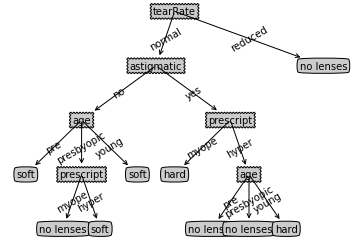

In [79]:
import os
fr=open('lenses.txt')
lenses=[inst.strip().split('\t') for inst in fr.readlines()]
## readlines() 表示逐行读取  inst.strip().split('\t') for inst in fr.readlines()  把文件中的每一行读为一个列表
lensesLabels=['age','prescript','astigmatic','tearRate']
lensesTree=createTree(lenses,lensesLabels)
print(lensesTree)
createPlot(lensesTree)

### 总结
决策树算法的具体步骤为：
* 创建树
  * 读取数据集合 
  * 计算数据集的熵
  * 计算信息增益 寻求最优划分方案
  
* 打印树

在决策树的建立过程中，比如上述的隐形眼镜例子中，会出现过拟合的情况 树分的太细了 导致出现过多的数据划分从而产生过度匹配数据集的问题。对此，我们可以通过对其进行**剪枝**，合并相邻两个无法产生较大信息增益的节点，从而消除过度匹配的问题。